<a href="https://colab.research.google.com/github/DSE-Group7/5g-energy-consumption-modeling/blob/samith-notebooks/Notebooks/Samith/samith_attempt5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gc
import os
import itertools
import pickle
import re
import time

import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

from functools import reduce
from tqdm import tqdm
from itertools import cycle
from scipy import stats
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

import lightgbm as lgb
import xgboost as xgb

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
pcp_df = pd.read_csv("/content/drive/MyDrive/competitions/input/power_consumption_prediction.csv")
cl_df = pd.read_csv("/content/drive/MyDrive/competitions/input/CLdata.csv")
bs_df = pd.read_csv("/content/drive/MyDrive/competitions/input/BSinfo.csv")
ec_df  = pd.read_csv("/content/drive/MyDrive/competitions/input/ECdata.csv")
ss_df = pd.read_csv("/content/drive/MyDrive/competitions/input/SampleSubmission.csv")

pcp_df.shape, cl_df.shape, bs_df.shape, ec_df.shape, ss_df.shape

((26139, 17), (125575, 10), (1217, 8), (92629, 3), (26139, 4))

In [3]:
ss_df.head()

,Time,BS,Energy,w
0,2023-01-01 06:00:00,B_0,NaN,1
1,2023-01-01 11:00:00,B_0,NaN,1
2,2023-01-01 12:00:00,B_0,NaN,1
3,2023-01-01 13:00:00,B_0,NaN,1
4,2023-01-01 23:00:00,B_0,NaN,1


In [4]:
bs_df.head()

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934
2,B_2,Cell0,Type1,Mode2,365.0,20,4,6.875934
3,B_3,Cell0,Type2,Mode2,532.0,20,4,6.875934
4,B_4,Cell0,Type2,Mode2,532.0,20,4,6.875934


In [5]:
ec_df.head()

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [6]:
cl_df.head()

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0


In [7]:
# calculate the number of BS in cl_df
num_bs = cl_df['BS'].nunique()
num_bs

1020

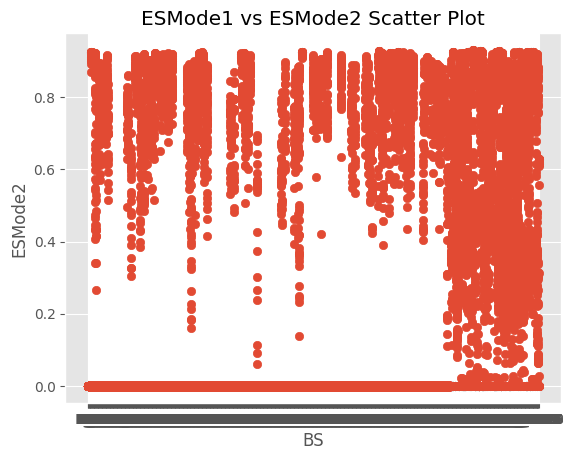

In [8]:
# show the ESMode1 scatter plot
import matplotlib.pyplot as plt

plt.scatter(cl_df['BS'], cl_df['ESMode6'])
plt.xlabel('BS')
plt.ylabel('ESMode2')
plt.title('ESMode1 vs ESMode2 Scatter Plot')
plt.show()


In [9]:
# remove ESMODE3,ESMODE4 and ESMODE5
cl_df = cl_df.drop(['ESMode3', 'ESMode4', 'ESMode5'], axis=1)
cl_df.head()

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0


In [10]:
# change the columns of the cl_df dataframe to lowercase
cl_df.columns = cl_df.columns.str.lower()
cl_df.head()

,time,bs,cellname,load,esmode1,esmode2,esmode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0


In [11]:
# add columns Cell0,Cell1,Cell2,Cell3 and values of those columns are default 0 but if there is an entry with relevant Cellnumber, the value should be load
cl_df['Cell0'] = 0
cl_df['Cell1'] = 0
cl_df['Cell2'] = 0
cl_df['Cell3'] = 0
cl_df.head()



,time,bs,cellname,load,esmode1,esmode2,esmode6,Cell0,Cell1,Cell2,Cell3
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0,0,0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0,0,0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0,0,0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0,0,0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0,0,0
